#### Import Dependencies

In [1]:
%matplotlib inline 

In [2]:
from vgg16_avg import VGG16_Avg

Using TensorFlow backend.


In [3]:
import keras 
from scipy.optimize import fmin_l_bfgs_b
from PIL import Image
import numpy as np
from keras.models import Model, Sequential
from keras import backend as K 
from scipy.misc import imsave
import matplotlib.pyplot as plt
import scipy

In [4]:
import os 
BASE_DIR = os.getcwd()

In [5]:
BASE_DIR

'C:\\Users\\vs76289\\Desktop\\fastai\\c2\\styleTransfer'

In [6]:
data_dir = os.path.join(BASE_DIR,'img')

In [7]:
data_dir

'C:\\Users\\vs76289\\Desktop\\fastai\\c2\\styleTransfer\\img'

#### Problem Formulation

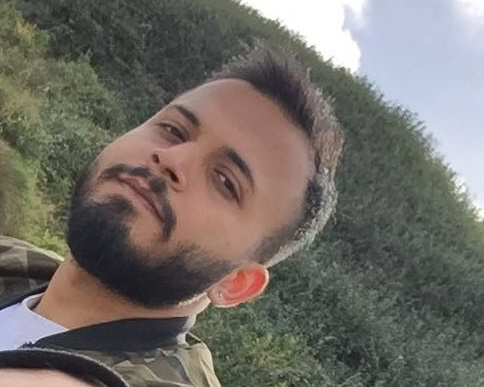

In [8]:
#content_img = Image.open(os.path.join(data_dir,'content.jpg')); content_img
content_img = Image.open('D:\dl\c2\courses\deeplearning2\work\data\cont.jpg'); content_img

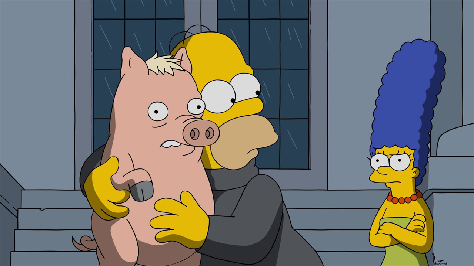

In [9]:
# style_img = Image.open(os.path.join(data_dir,'style.jpg')); style_img
style_img = Image.open('D:\\dl\\c2\\courses\\deeplearning2\\work\\data\\simpson.png'); style_img

#### Preprocessing

In [10]:
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)

In [11]:
preproc = lambda x: (x - vgg_mean)[:, :, :, ::-1]

In [12]:
depreproc = lambda x,s: np.clip( x.reshape(s)[:, :, :, ::-1] + vgg_mean,0,255)

In [13]:
content = preproc(np.expand_dims(np.array(content_img), 0))
content_shape = content.shape

In [14]:
style = preproc(np.expand_dims(np.array(style_img), 0))
style_shape = style.shape

#### Extracting Content 

In [15]:
features  = VGG16_Avg(include_top = False)

In [16]:
features.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, None, None, 128)   0         
__________

In [17]:
layer = features.get_layer('block5_conv1').output

In [18]:
content_model = Model(features.input, layer)

In [19]:
targ = K.variable(content_model.predict(content))

In [20]:
class Evaluator(object):
    
    def __init__(self,f,shp): self.f, self.shp = f, shp
    
    def loss(self,x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

In [21]:
loss = K.mean(keras.metrics.mse(layer,targ))
grads = K.gradients(loss,content_model.input)
fn = K.function([content_model.input], [loss]+grads)
evaluator = Evaluator(fn,content_shape)

In [26]:
def solve_image_content(eval_obj, niter, x):    
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(), fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x,-127,127)
        print('Current Loss function is: ', min_val)
        imsave('content_at_itr_{}.jpg'.format(i), depreproc(x.copy(), content_shape)[0])
    return x

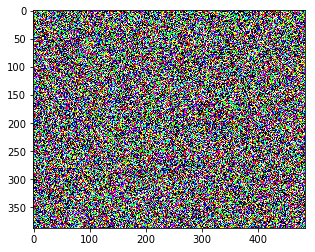

In [23]:
rand_img = lambda shape: np.random.uniform(-2.5,2.5,shape)/100
x = rand_img(content_shape)
plt.imshow(x[0])

In [24]:
iterations = 10 

In [27]:
x = solve_image_content(evaluator, iterations, x)

Current Loss function is:  42.7317619324
Current Loss function is:  16.3581771851
Current Loss function is:  9.24890232086
Current Loss function is:  6.30420303345
Current Loss function is:  4.82129764557
Current Loss function is:  3.95441555977
Current Loss function is:  3.34514188766
Current Loss function is:  2.98197603226
Current Loss function is:  2.65496063232
Current Loss function is:  2.4078567028


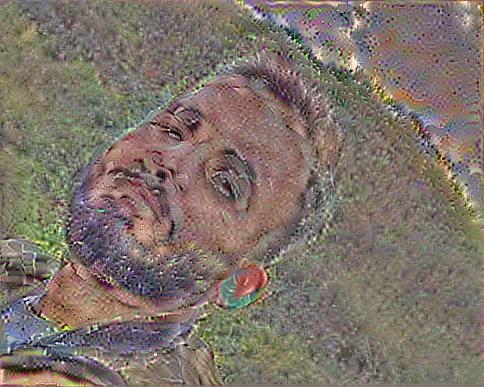

In [28]:
Image.open('C:\\Users\\vs76289\\Desktop\\fastai\\c2\\styleTransfer\\content_at_itr_9.jpg')

#### Extracting Style

In [29]:
def plot_arr(arr): plt.imshow(depreproc(arr,arr.shape)[0].astype('uint8'))

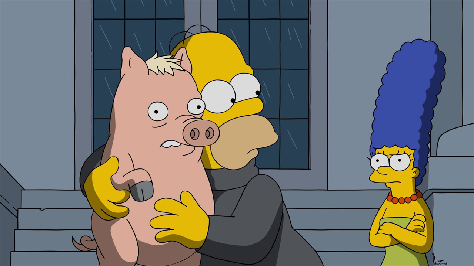

In [30]:
style_img

In [31]:
style_features = VGG16_Avg(include_top=False, input_shape = style.shape[1:])
outputs = {l.name: l.output for l in style_features.layers}

In [32]:
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,3)]

In [58]:
layers

[<tf.Tensor 'block1_conv1_1/Relu:0' shape=(?, 266, 474, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1_1/Relu:0' shape=(?, 133, 237, 128) dtype=float32>]

In [33]:
style_model = Model(style_features.input, layers)

In [34]:
style_targs = [K.variable(o) for o in style_model.predict(style)]

In [35]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [36]:
def style_loss(x, targ): return K.mean(keras.metrics.mse(gram_matrix(x), gram_matrix(targ)))

In [37]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(layers, style_targs))
grads = K.gradients(loss, style_model.input)
style_fn = K.function([style_model.input], [loss]+grads)
evaluator = Evaluator(style_fn, style_shape)

In [38]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1
x = rand_img(style.shape)
x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])

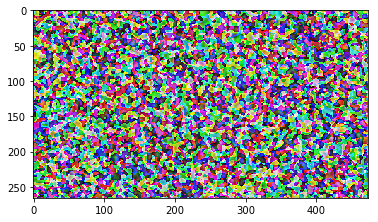

In [39]:
plt.imshow(x[0])

In [40]:
iterations=10

In [41]:
def solve_image_style(eval_obj, niter, x):    
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(), fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x,-127,127)
        print('Current Loss function is: ', min_val)
        imsave('style_at_itr_{}.jpg'.format(i), depreproc(x.copy(), style.shape)[0])
    return x

In [42]:
x = solve_image_style(evaluator, iterations, x)

Current Loss function is:  5439.37109375
Current Loss function is:  679.999328613
Current Loss function is:  169.421875
Current Loss function is:  72.0561752319
Current Loss function is:  39.5626754761
Current Loss function is:  24.3839263916
Current Loss function is:  16.9249534607
Current Loss function is:  12.6334590912
Current Loss function is:  9.84837913513
Current Loss function is:  8.01692390442


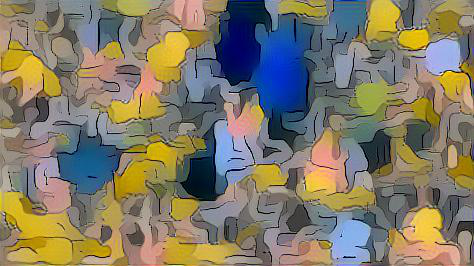

In [43]:
Image.open('C:\\Users\\vs76289\\Desktop\\fastai\\c2\\styleTransfer\\style_at_itr_9.jpg')

#### Style Transfer

In [44]:
style.shape

(1, 266, 474, 3)

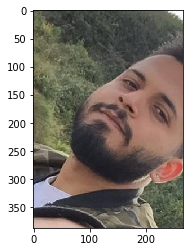

In [45]:
_,w,h,_ = style_shape
src = content[:,:h,:w]
plot_arr(src)

In [71]:
style.shape

(1, 266, 474, 3)

In [70]:
src.shape

(1, 387, 266, 3)

In [79]:
content_shape

(1, 387, 484, 3)

In [83]:
model = VGG16_Avg(include_top=False, input_shape=content_shape[1:])

In [84]:
outputs = {l.name: l.output for l in model.layers}

In [85]:
outputs

{'block1_conv1': <tf.Tensor 'block1_conv1_6/Relu:0' shape=(?, 387, 484, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_6/Relu:0' shape=(?, 387, 484, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_6/AvgPool:0' shape=(?, 193, 242, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_6/Relu:0' shape=(?, 193, 242, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_6/Relu:0' shape=(?, 193, 242, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_6/AvgPool:0' shape=(?, 96, 121, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_6/Relu:0' shape=(?, 96, 121, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_6/Relu:0' shape=(?, 96, 121, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_6/Relu:0' shape=(?, 96, 121, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_6/AvgPool:0' shape=(?, 48, 60, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_6/Relu:0' shape=(?, 48, 60, 512) d

In [86]:
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]
content_name = 'block4_conv2'
content_layer = outputs[content_name]

In [87]:
style_layers

[<tf.Tensor 'block1_conv2_6/Relu:0' shape=(?, 387, 484, 64) dtype=float32>,
 <tf.Tensor 'block2_conv2_6/Relu:0' shape=(?, 193, 242, 128) dtype=float32>,
 <tf.Tensor 'block3_conv2_6/Relu:0' shape=(?, 96, 121, 256) dtype=float32>,
 <tf.Tensor 'block4_conv2_6/Relu:0' shape=(?, 48, 60, 512) dtype=float32>,
 <tf.Tensor 'block5_conv2_6/Relu:0' shape=(?, 24, 30, 512) dtype=float32>]

In [88]:
content_layer

<tf.Tensor 'block4_conv2_6/Relu:0' shape=(?, 48, 60, 512) dtype=float32>

In [89]:
style_model_transfer = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model_transfer.predict(style)]

ValueError: Error when checking : expected input_7 to have shape (None, 387, 484, 3) but got array with shape (1, 266, 474, 3)

In [66]:
style_targs

[<tf.Variable 'Variable_9:0' shape=(1, 266, 474, 64) dtype=float32_ref>,
 <tf.Variable 'Variable_10:0' shape=(1, 133, 237, 128) dtype=float32_ref>,
 <tf.Variable 'Variable_11:0' shape=(1, 66, 118, 256) dtype=float32_ref>,
 <tf.Variable 'Variable_12:0' shape=(1, 33, 59, 512) dtype=float32_ref>,
 <tf.Variable 'Variable_13:0' shape=(1, 16, 29, 512) dtype=float32_ref>]

In [68]:
content_model_transfer = Model(model.input, content_layer)
content_targ = K.variable(content_model_transfer.predict(src))

ValueError: Error when checking : expected input_4 to have shape (None, 266, 474, 3) but got array with shape (1, 387, 266, 3)

In [ ]:
style_wgts = [0.05,0.2,0.2,0.25,0.3]

In [ ]:
loss = sum(style_loss(l1[0], l2[0])*w  
           for l1,l2,w in zip(style_layers, style_targs, style_wgts)) 

In [ ]:
loss += K.mean(keras.metrics.mse(content_layer, content_targ)/10)
grads = K.gradients(loss, features.input)
transfer_fn = K.function([features.input], [loss]+grads)

In [ ]:
evaluator = Evaluator(transfer_fn, shp)

In [ ]:
iterations=10
x = rand_img(shp)

In [ ]:
def solve_image_styleTransfer(eval_obj, niter, x):    
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(), fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x,-127,127)
        print('Current Loss function is: ', min_val)
        imsave('styleTransfer_at_itr_{}.jpg'.format(i), depreproc(x.copy(), shp)[0])
    return x

In [ ]:
x = solve_image_styleTransfer(evaluator, iterations, x)